# **Vehicle Detection for Autonomous Cars** 
***

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.

### Import Packages

In [49]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Test Vehicle Detection in Images

Built my pipeline to work on the images in the directory "test_images"

In [50]:
import os

# print test images file name
test_images_names = os.listdir("test_images/")
print(test_images_names)

['feature-extraction', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


### Read in the Test Image
I'll test each step of my pipeline on the following test image

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


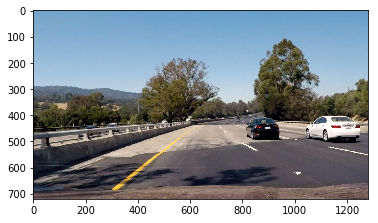

In [391]:
#reading in a test image
test_image = mpimg.imread('test_images/test4.jpg')

# printing out some stats and plotting
print('This image is:', type(test_image), 'with dimesions:', test_image.shape)
plt.imshow(test_image) 

### Draw Boxes Manually to Prototype
This function takes an image, a list of bounding boxes, and optional color tuple and line thickness as inputs and then draws boxes in that color on the output

In [52]:
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
            cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img 

Test drawing boxes on the test image

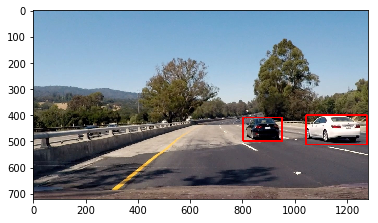

In [423]:
# manually set the coordinates of the vehicule boxes 
bboxes = [((951, 498), (803, 409)), ((1276, 512), (1043, 401))]

result = draw_boxes(test_image, bboxes)
plt.imshow(result)

## Vehicle Feature Extraction

Test Feature Extraction on this test vehicle image

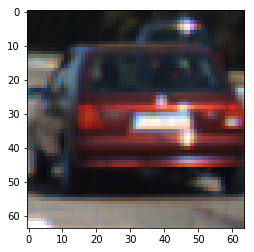

In [219]:
#reading in a vehicle test image
test_vehicle_image = mpimg.imread('test_images/feature-extraction/7.png')
plt.imshow(test_vehicle_image) 

### Binned Color Feature Extraction
This function extracts Binned Color features of an image

In [220]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

Test Binned Color Feature Extraction on a test image

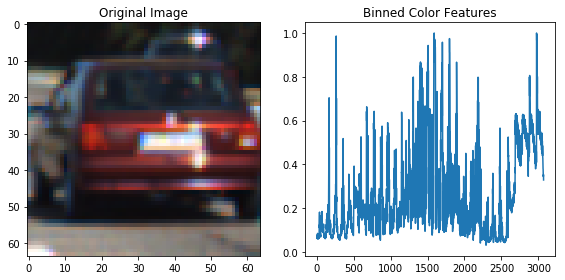

In [221]:
# Define Binned Color Feature Extraction parameters
test_size = (32,32)

test_features_binned_color = bin_spatial(test_vehicle_image, test_size)

# Plot an example of raw and binned color features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_vehicle_image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(test_features_binned_color)
plt.title('Binned Color Features')
fig.tight_layout()

### Histogram-of-Colors Feature Extraction

This function extracts histogram-of-colors features of an image

In [222]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

Plot Histogram of Color-Space feature extraction of Test Image

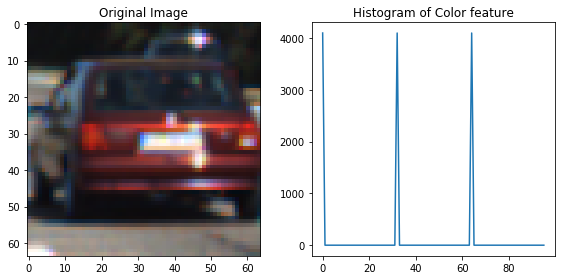

In [230]:
# Define HOC parameters
test_hist_bins =32
test_bins_range=(0, 256)

test_features_hoc = color_hist(test_vehicle_image, test_hist_bins, test_bins_range)

# Plot an example of raw and histogram-of-color features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_vehicle_image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(test_features_hoc)
plt.title('Histogram of Color feature')
fig.tight_layout()

### Histogram-of-Gradients Feature Extraction
This function takes in a vehicle image and returns a Histogram of Gradients feature vector of an image

In [224]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
        

Test the Histogram of Gradient feature extraction on a test image and Visualize HOG Image

C:\Users\Vincent\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


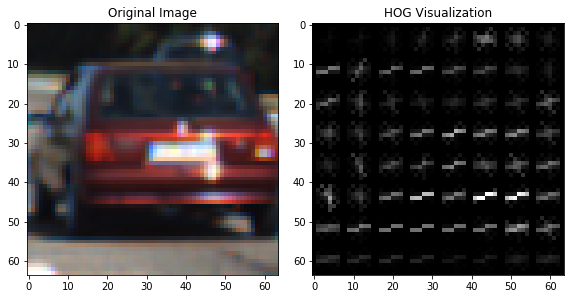

In [225]:
# Define HOG parameters
test_orient = 9
test_pix_per_cell = 8
test_cell_per_block = 2
test_hog_channel = 0

# Call our function with vis=True to see an image output
test_features_hog, hog_image = get_hog_features(test_vehicle_image[:,:,test_hog_channel], test_orient, 
                        test_pix_per_cell, test_cell_per_block, 
                        vis=True, feature_vec=False)

# Plot an example of raw and HOG Image
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_vehicle_image)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
fig.tight_layout()

Plot Histogram of Gradient feature extraction

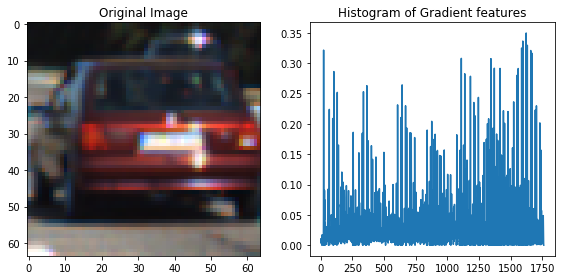

In [226]:
test_features_hog = test_features_hog.ravel() 

# Plot an example of raw and gradient features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_vehicle_image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(test_features_hog)
plt.title('Histogram of Gradient features')
fig.tight_layout()

### Combine Binned Color, HOC and HOG Features

This function combines the extracted Binned Color, Histogram-of-Color and Histogram-of-Gradient features of a single image

In [242]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append features to list
        img_features.append(hist_features)
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append features to list
        img_features.append(hog_features)

    # Return concatenated array of features
    return img_features

Test combining Binned Color, HOC and HOG Features on the Test Image

C:\Users\Vincent\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


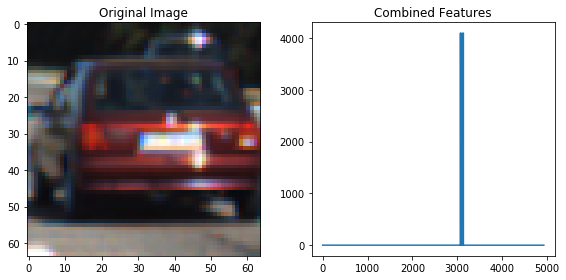

In [248]:

test_features_combined = single_img_features(test_vehicle_image, test_color_space, test_size,
                        test_hist_bins, test_orient, 
                        test_pix_per_cell, test_cell_per_block, test_hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

test_features_combined_plot = np.concatenate(test_features_combined)

# Plot an example of raw and combined features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_vehicle_image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(test_features_combined_plot)
plt.title('Combined Features')
fig.tight_layout()

## Build a Classifier to classify Vehicles and Non-Vehicles

### Explore Vehicles and Non-Vehicles Datasets

Load Datasets

In [232]:
import glob

cars = glob.glob('datasets/cars/**/*.png', recursive=True)
notcars = glob.glob('datasets/notcars/**/*.png', recursive=True)

This function returns some characteristics of the dataset 

In [233]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)

print('Dataset has', data_info["n_cars"], 'cars and', data_info["n_notcars"], 'non-cars'
    ,'\neach of size: ',data_info["image_shape"], 'and data type:', data_info["data_type"])

Dataset has 8792 cars and 8968 non-cars 
each of size:  (64, 64, 3) and data type: float32


Plot example images of random car / not-car from the dataset

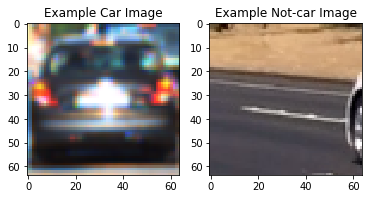

In [234]:
# Pick random index
test_car_ind = np.random.randint(0, len(cars))
test_notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
test_car_image = mpimg.imread(cars[test_car_ind])
test_notcar_image = mpimg.imread(notcars[test_notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(test_car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(test_notcar_image)
plt.title('Example Not-car Image')

### Extract Features and Labels from Dataset

This function iterates through each image in a dataset and extracts its combined binned color, HOC and HOG features

In [247]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # Extract features of each image in dataset
        file_features = single_img_features(image, color_space, spatial_size,
                                hist_bins, orient, 
                                pix_per_cell, cell_per_block, hog_channel,
                                spatial_feat=True, hist_feat=True, hog_feat=True)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

Extract features from the cars and notcars datasets

In [246]:
# Features Extraction Parameters
color_space='RGB'
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel=0
spatial_feat=True
hist_feat=True
hog_feat=True

print('Extracting features from the cars and notcars datasets...')
car_features = extract_features(cars, color_space, spatial_size, hist_bins, 
                        orient, pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)

notcar_features = extract_features(notcars, color_space, spatial_size, hist_bins, 
                        orient, pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)

print('Successfully extracted features from the cars and notcars datasets.')

Extracting features from the cars and notcars datasets...


C:\Users\Vincent\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Successfully extracted features from the cars and notcars datasets.


Create the normalized features vector for the combined dataset

In [251]:
from sklearn.preprocessing import StandardScaler

print('Creating the normalized features vector...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print('Successfully created the normalized features vector.')

Creating the normalized features vector...
Successfully created the normalized features vector.


Plot the scaled features of a random car from the dataset

C:\Users\Vincent\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


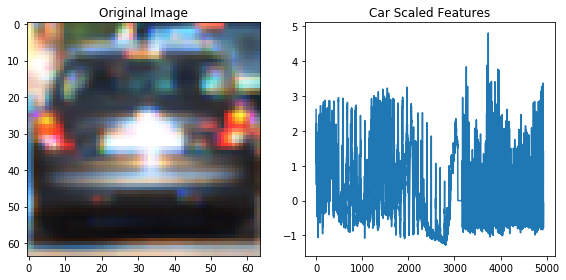

In [308]:
test_car_features = car_features[test_car_ind]
test_car_features_scaled = X_scaler.transform(test_car_features)

fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[test_car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(test_car_features_scaled)
plt.title('Car Scaled Features')
fig.tight_layout()

Plot the scaled features of a random notcar from the dataset

C:\Users\Vincent\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


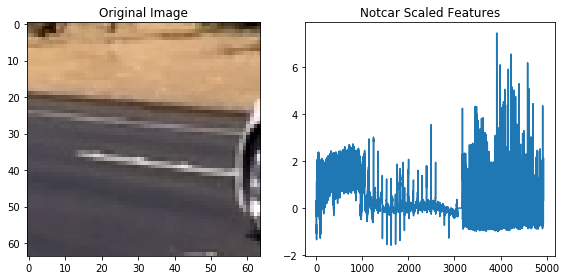

In [309]:
test_notcar_features = notcar_features[test_notcar_ind]
test_notcar_features_scaled = X_scaler.transform(test_notcar_features)

fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(notcars[test_notcar_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(test_notcar_features_scaled)
plt.title('Notcar Scaled Features')
fig.tight_layout()

Create the labels vector for the dataset (1's for cars, 0's for non-cars).

In [252]:
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

Shuffle and split the data into training and testing sets

In [253]:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

### Support Vector Machine Classifier

Build and Train the Classifier

In [254]:
from sklearn import svm, model_selection

print('Training the classifier...')

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

print('Successfully trained the classifier.')
print('\nBest parameters chosen by GridSearchCV:', clf.best_params_)
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

Training the classifier...
Successfully trained the classifier.

Best parameters chosen by GridSearchCV: {'kernel': 'rbf', 'C': 10}
Test Accuracy of SVC =  0.9961


## Implement Sliding Window Search

### Get Sliding Windows
This function takes windows start/stop positions, windows size and windows overlap, and returns a list of bounding boxes for the search windows

In [463]:
def slide_window(img, x_start_stop, y_start_stop, 
                    xy_window, xy_overlap=(0.5, 0.5)):
    # Initialize a list to append window positions to
    window_list = []
    for i in range(len(test_xy_window)):
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[i][0] == None:
            x_start_stop[i][0] = 0
        if x_start_stop[i][1] == None:
            x_start_stop[i][1] = img.shape[1]
        if y_start_stop[i][0] == None:
            y_start_stop[i][0] = 0
        if y_start_stop[i][1] == None:
            y_start_stop[i][1] = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[i][1] - x_start_stop[i][0]
        yspan = y_start_stop[i][1] - y_start_stop[i][0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[i][0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[i][1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[i][0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[i][1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Loop through finding x and y window positions
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[i][0]
                endx = startx + xy_window[i][0]
                starty = ys*ny_pix_per_step + y_start_stop[i][0]
                endy = starty + xy_window[i][1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

Draw Search Windows on a Test Image

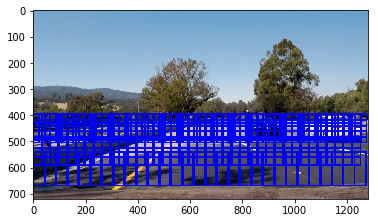

In [558]:
# Test image shape
test_image_height = test_image.shape[0]
test_image_width = test_image.shape[1]

# Parameters for small windows
test_x_start_stop_small=[0, test_image_width]
test_y_start_stop_small=[int(test_image_height*0.55), int(test_image_height*0.70)]
test_xy_window_small=(64, 64)

# Parameters for medium windows
test_x_start_stop_medium=[0, test_image_width]
test_y_start_stop_medium=[int(test_image_height*0.55), int(test_image_height*0.85)]
test_xy_window_medium=(96, 96)

# Parameters for large windows
test_x_start_stop_large=[0, test_image_width]
test_y_start_stop_large=[int(test_image_height*0.75), int(test_image_height*0.95)]
test_xy_window_large=(128, 128)

# Prepare Parameters for slide_window() function
test_x_start_stop = [test_x_start_stop_small, test_x_start_stop_medium, test_x_start_stop_large]
test_y_start_stop = [test_y_start_stop_small, test_y_start_stop_medium, test_y_start_stop_large]
test_xy_window = [test_xy_window_small, test_xy_window_medium, test_xy_window_large]

test_xy_overlap=(0.65, 0.65)

test_windows = slide_window(test_image, test_x_start_stop, test_y_start_stop, 
                    test_xy_window, test_xy_overlap)

window_img = draw_boxes(test_image, test_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

### Search Sliding Windows and Detect Vehicle Windows

In [559]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # Extract features for that window using single_img_features()
        features_window = single_img_features(img_window, color_space, 
                            spatial_size, hist_bins, 
                            orient, pix_per_cell, cell_per_block, hog_channel, 
                            spatial_feat, hist_feat, hog_feat)
        features_window_concat = np.concatenate(features_window)
        # Scale extracted features to be fed to classifier
        features_window_scaled = scaler.transform(np.array(features_window_concat).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(features_window_scaled)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows

Test Detecting Vehicle Windows in Test Image

C:\Users\Vincent\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


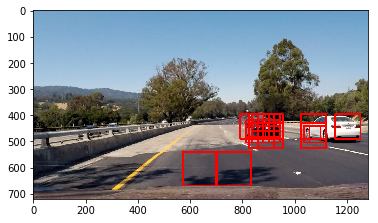

In [560]:
# extracted training data from .png images (scaled 0 to 1 by mpimg) 
# but test images are .jpg (scaled 0 to 255)
test_image_corr = test_image.astype(np.float32)/255

test_hot_windows = search_windows(test_image_corr, test_windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)                       

test_window_img = draw_boxes(test_image, test_hot_windows, color=(255, 0, 0), thick=6)                    

plt.imshow(test_window_img)

### Removing False-Positive Windows

This function adds "heat" to a heat-map for a list of bounding boxes

In [561]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

This function threshold the heat-map to reject areas affected by false positives

In [562]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

Test thresholding the heat-map of the Test Image

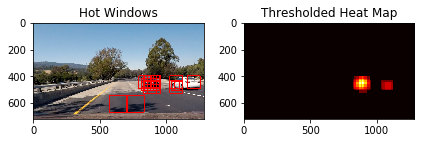

In [563]:
test_heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
test_heat = add_heat(test_heat,test_hot_windows)
test_heat = apply_threshold(test_heat,1)

fig = plt.figure()
plt.subplot(121)
plt.imshow(test_window_img)
plt.title('Hot Windows')
plt.subplot(122)
plt.imshow(test_heat, cmap='hot')
plt.title('Thresholded Heat Map')
fig.tight_layout()

Figure out how many cars there are in each frame and which pixels belong to which cars

2 cars found


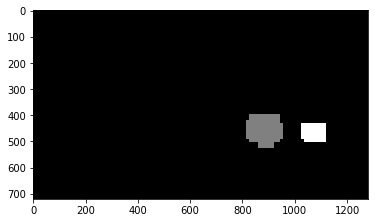

In [564]:
from scipy.ndimage.measurements import label

test_labels = label(test_heat)
print(test_labels[1], 'cars found')
plt.imshow(test_labels[0], cmap='gray')

 This function takes the labels image and puts bounding boxes around the labeled regions

In [565]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

Test drawing bounding boxes around the labeled regions of the Test Image

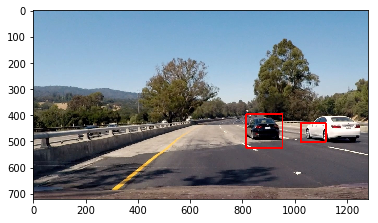

In [566]:
# Draw bounding boxes on a copy of the test image
draw_img = draw_labeled_bboxes(np.copy(test_image), test_labels)
# Display the image
plt.imshow(draw_img)